In [1]:
from sympy import *
interactive.printing.init_printing(use_latex=True)
from sympy.physics.vector import *
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import axes3d
warnings.simplefilter('ignore')
import multiprocessing as mp

# for vector operations
N = ReferenceFrame('N')

In [2]:
### dog cone properties ### 

rf = 0.075 # radius of quarz fiber/rod
rc = 0.09 # small radius of dog cone
RC = 0.2066726188957803 # big radius of dog cone
a = 3*pi/8 # angle of the cone
lc = ((2*rf + rc - rf)*sin(pi/4)/sin(a-pi/4)).evalf() # length of the cone (straight line along the surface)
hc = (lc*sin(a)).evalf() # height of the cone itself
cone_grid = np.zeros((5,25)) # boolean grid (0=False,1=True). Specifies whether rod 'm,k' has a dog cone.
for i in range(cone_grid.shape[1]): 
    cone_grid[:,i] = (i+1)%2 # even places get dog cone, odd don't

### general properties of the system ###

xb = 4.89/2 # base limits are (-xb,xb)x(-yb,yb) [cm], it's located on z=0 plane
yb = 4.64/2 # this bounds but doesn't determine the rod grid. This only effect parallel ray generation (for sanity checks).
xp = 0.50 # PMT limits are (-xp,xp)x(-yp,yp) [cm], located on z=h plane
yp = 0.58 # this data is accurately taken from the ZDC solidworks assembly
h = 7 # distance from the source grid plane, to the PMT plane.
p_absorb = 0.1 # this is the probability for a photon to get absorbed in the metal instead of reflecting

### properties of the light sources (rods)

x0 = 1.4 # furthest chamber from the symmetry axis (along beam axis)
y0 = 2.16 # furthest rod from the symmetry axis (along chamber axis)
x_source = np.linspace(-x0,x0,5) # 5 chambers along the (real) beam axis, roughly spaced 0.7[cm] apart.
y_source = np.linspace(-y0,y0,25) # 25 rods per chamber, roughly spaced 0.18[cm] apart (minimal spacing is 0.15[cm] corresponding to the rod diameter)
source_grid = np.meshgrid(x_source,y_source) # the rod 'm,k' will be located at x=grid[0][k,m] and y=grid[1][k,m]
#offset_grid = cone_grid * 0.5 # the rod 'm,k' will be located at z=offset_grid[m,k] (dog cone should be higher).
offset_grid = cone_grid * 0

### winston cone
m = -0.5*(xp**2+yp**2)**(-0.5) # this is a paraboloid focused at (0,0,h)- the only one to pass through (xp,yp,h)
winston_cone = m*(N[0]**2 + N[1]**2) + h - 1/(4*m) # this should be a protected variable!!!

### CMOS detector
x_cmos = 2.35
y_cmos = 1.56

In [5]:
def Ray_Generator_ZDC():
    # Chooses a fiber/rod in random, from a defined grid
    np.random.seed()
    nx = np.random.randint(0,source_grid[0].shape[1])
    ny = np.random.randint(0,source_grid[0].shape[0])
    xc = source_grid[0][ny,nx]
    yc = source_grid[1][ny,nx]
    zc = offset_grid[nx,ny]

    # The ray is generated from a random point on the circular base surface of the rod (radius rf)
    rand_arg = np.random.uniform(-np.pi,np.pi)
    rand_rad = rf*np.sqrt(np.random.uniform(0,1)) # Inversion sampling
    xs = xc + rand_rad * np.cos(rand_arg)
    ys = yc + rand_rad * np.sin(rand_arg)
    pc = xc * N.x + yc * N.y + zc * N.z
    ps = xs * N.x + ys * N.y + zc * N.z
    
    # Chooses random orientation for the ray, polar angle distributed normally around 45 degrees. Narrow width.
    theta = np.random.normal(np.pi/4,np.pi/12)
    phi = np.random.uniform(-np.pi,np.pi)
    es = np.cos(phi)*np.sin(theta) * N.x + np.sin(phi)*np.sin(theta) * N.y + np.cos(theta) * N.z 
    
    # Returns a point 'ps' and a unit vector 'es', which characterize a straight line (the light ray before reflection).
    # returns tuplet (nx,ny)
    return ps,es,(nx,ny)

def Ray_Generator_Parallel():
    # mostly for sanity checks
    np.random.seed()
    xs = np.random.uniform(-xb,xb)
    ys = np.random.uniform(-yb,yb)
    
    ps = xs*N.x + ys*N.y
    es = 1*N.z
    return ps,es

ray_x = lambda z,p,e: (p & N.x)+(e & N.x)/(e & N.z)*(z-(p & N.z))
ray_y = lambda z,p,e: (p & N.y)+(e & N.y)/(e & N.z)*(z-(p & N.z))

def Ray_Generator_Origin(theta,sigma):
    # random ray from a rod sitting on the origin (0,0,0)
    # user controls angular distribution: gaussian around theta (degrees) with width sigma (degrees)
    # spatial distribution is uniform on the rod surface
    np.random.seed()
    rand_arg = np.random.uniform(-np.pi,np.pi)
    rand_rad = rf*np.sqrt(np.random.uniform(0,1)) # Inversion sampling
    xs = rand_rad * np.cos(rand_arg)
    ys = rand_rad * np.sin(rand_arg)
    ps = xs * N.x + ys * N.y
    
    polar_ang = np.random.normal(loc = np.deg2rad(theta), scale = np.deg2rad(sigma))
    azi_ang = np.random.uniform(-np.pi,np.pi)
    
    es = np.cos(azi_ang)*np.sin(polar_ang) * N.x + np.sin(azi_ang)*np.sin(polar_ang) * N.y + np.cos(polar_ang) * N.z
    
    return ps,es

def CMOS_projection(theta,sigma,N_ray,z_cmos,cone=False): 
    data_mat = np.zeros((N_ray,2)) ## going to store (x,y) for photons hitting 'z_cmos' plane, where CMOS is located.
    for i in range(N_ray):
        ps,es = Ray_Generator_Origin(theta,sigma)
        if (cone):
            ps,es = Dog_Cone(ps,es,(2,12)) ## tuplet for rod at (0,0)
        if (float(es & N.z) == 0 ):
            i -= 1 ## won't hit the CMOS, doesn't help us generate statistics. We replace this ray.
        else: ## ray will hit the 'z=z_cmos' plane.
            data_mat[i,0] = ray_x(z_cmos,ps,es)
            data_mat[i,1] = ray_y(z_cmos,ps,es)
    
    figure = plt.figure(figsize=(20,10))
    plt.rc('font',size=12)
    
    ax1 = plt.subplot(121)
    ax1.scatter(data_mat[:,0],data_mat[:,1],c='Crimson',label='photons traced')
    cmos_shape = plt.Rectangle((-x_cmos/2,-y_cmos/2),width=x_cmos,height=y_cmos,color='SteelBlue',fill=False,ls='--',lw=3,label='cmos limits')
    xlim = np.max(data_mat[:,0])
    ylim = np.max(data_mat[:,1])
    ax1.set_xlim(left=-xlim,right = xlim)
    ax1.set_ylim(bottom= -ylim ,top = ylim)
    ax1.add_patch(cmos_shape)
    ax1.title.set_text(f'photon scatter on z={z_cmos}[cm] plane,dog cone={cone}')
    ax1.set_xlabel('x [cm]')
    ax1.set_ylabel('y [cm]')
    ax1.legend()
    
    ax2 = plt.subplot(122)
    rad_vec = np.sqrt(data_mat[:,0]**2 + data_mat[:,1]**2)
    ndata,rdata,_ = ax2.hist(rad_vec,density=True,bins=20)
    ## finding maximum power radius
    nmax = np.max(ndata)
    index = np.argmax(ndata)
    rmax = (rdata[index]+rdata[index+1])/2
    rbin = (rdata[index+1]-rdata[index])
    ## finding fwhm- important!
    helparr = np.abs(ndata - nmax/2)
    indexl = np.argmin(helparr[:index])
    rleft = rdata[indexl] 
    indexr = np.argmin(helparr[index+1:]) + index + 1
    rright = rdata[indexr]
    fwhm = rright-rleft
    ax2.text(rright+rbin,nmax/2,f'r={rmax:1.3g}[cm]',fontsize=14)
    ax2.text(rright+rbin,nmax/2-0.25,f'fwhm={fwhm:1.3g}[cm]',fontsize=14)
    ax2.vlines(rmax,0,nmax,color='Gold',ls='--',lw=3,label='maximum power')
    ax2.hlines((ndata[indexr]+ndata[indexl])/2,rleft,rright+rbin,color='Orchid',ls='--',lw=3,label='half maximum power')
    ax2.set_xlabel('r [cm]')
    ax2.title.set_text('radial distribution of power')
    ax2.legend()
    
    plt.show()
    
    return rmax,fwhm
            

def Intersection(surface,p,e,bottom,top):
    # takes in the equation of the reflector surface
    # and also a point and a vector, describing a light ray traveling along a straight line
    if ((e & N.z) == 0):
        g = symbols('gamma',positive=True , real=True)
        xi = (p & N.x) + g * float(e & N.x)
        yi = (p & N.y) + g * float(e & N.y)
        zi = (p & N.z) + g * float(e & N.z)
        g_arr = np.array(solve(surface.subs([(N[0],xi),(N[1],yi)]),g,check=False)) # we will only get one solution
        xi = xi.subs(g,float(g_arr[0]))
        yi = yi.subs(g,float(g_arr[0]))
        return xi * N.x + yi * N.y
    else:
        x_z = (p & N.x) + (N[2] - (p & N.z))*(e & N.x)/(e & N.z)
        y_z = (p & N.y) + (N[2] - (p & N.z))*(e & N.y)/(e & N.z)
        surface = surface.subs([(N[0],x_z),(N[1],y_z)])
        sol = symbols('chi', positive=True, real=True) # this is needed because sympy doesn't handle radical equation very well
        surface = simplify(surface.subs(N[2],sol))
        sol_arr = np.array(solve(sol - surface,sol)) ## solve for intersection z
    for i in range(len(sol_arr)):
        if sol_arr[i].is_real:
            zi = float(sol_arr[i])
            if bottom <= zi <= top : ## if the ray intersects the boundary inside the light guide, we return the intersection
                return x_z.subs(N[2],zi) * N.x + y_z.subs(N[2],zi) * N.y + zi * N.z
    return 0 * N.x + 0* N.y ## otherwise, we return (0,0,0) and thus know it doesn't reflect off of the boundary

def Bisection(surface,p,e,height):
    # same purpose as 'Intersection'
    # uses a numerical method for solving, instead of analytical
    g = symbols('gamma',positive=True,real=True)
    xi = (p & N.x) + g * (e & N.x) # this is the parametric representation of the light ray straight line
    yi = (p & N.y) + g * (e & N.y)
    zi = (p & N.z) + g * (e & N.z)
    eq = surface.subs([(N[0],xi),(N[1],yi),(N[2],zi)]) # we substitute for the intersection equation
    
    gl = 0 # we choose a very big bracket
    gr = 2*height
    
    index = 1
    gc = (gl + gr)/2
    cc = float(eq.subs(g,gc).evalf())
    while (index <= 20 and np.allclose(cc,0,atol=1e-3)==False):
        index += 1
        cl = float(eq.subs(g,gl).evalf())
        cr = float(eq.subs(g,gr).evalf())
        if (cl * cc <= 0): # move right side to maintain bracket
            gr = gc
        elif (cr * cc <= 0): # move left side to maintain bracket
            gl = gc
        else: # if there's no bracket, there's no root inside (in our case) and thus no intersection
            return 0 * N.x + 0* N.y # so we return (0,0), ergo no reflection.
        gc = (gl + gr)/2
        cc = float(eq.subs(g,gc).evalf())
    
    if (np.allclose(cc,0,atol=0.005)):
        return xi.subs(g,gc)*N.x + yi.subs(g,gc)*N.y + zi.subs(g,gc)*N.z
    else:
        return 0 * N.x + 0* N.y 


def Dog_Cone(ps,es,tup):
    # checkes if a ray coming out of a rod is deflected by the cone
    # if yes, returns the deflected ray. if no- returns same ray.
    nx,ny = tup
    xc = source_grid[0][ny,nx]
    yc = source_grid[1][ny,nx]
    zc = offset_grid[nx,ny]
    
    cone = (tan(a)*(((N[0]-xc)**2 + (N[1]-yc)**2)**0.5 - rc)).evalf() + zc
    intersect = Bisection(N[2]-cone,ps,es,zc+hc)
    if intersect == 0*N.x + 0*N.y:
        return ps,es
    else:
        ps = intersect
        ns = Grad_Vec(N[2]-cone,ps)
        es = Ref_Vec(es,ns)
        return ps,es
    
def Normal_Vec(surface,intersect):
    # Finds the normal vectors to a parametrized surface at point of intersection.
    # first we look at the cylindrical coordinate parametrization of surface
    rho, phi = symbols('rho phi')
    xs = rho * cos(phi)
    ys = rho * sin(phi)
    surface = simplify(surface.subs([(N[0],xs),(N[1],ys)])) # this is z(rho,phi)
    t1 = diff(xs,rho) * N.x + diff(ys,rho) * N.y + diff(surface,rho) * N.z # tangent 1 
    t2 = diff(xs,phi) * N.x + diff(ys,phi) * N.y + diff(surface,phi) * N.z # tangent 2
    n_vec = (t2 ^ t1)# cross product
    xi = float(intersect & N.x)
    yi = float(intersect & N.y)
    arg = np.arctan2(yi,xi)
    n_vec = n_vec.subs([(rho,np.sqrt(xi**2 + yi**2)) ,(phi,arg)])
    return n_vec.normalize()

def Grad_Vec(surface,intersect):
    # Takes a surface which is a LEVEL SET: f(x,y,z) = 0
    # Returns the gradient at the intersection points, which is exactly the normal vector at that point.
    xi = float(intersect & N.x)
    yi = float(intersect & N.y)
    zi = float(intersect & N.z)
    gx = diff(surface,N[0])
    gy = diff(surface,N[1])
    gz = diff(surface,N[2])
    n_vec = gx * N.x + gy * N.y + gz* N.z
    n_vec = n_vec.subs([(N[0],xi),(N[1],yi),(N[2],zi)]).evalf()
    return n_vec.normalize()

def Ref_Vec(e,n):
    # Calculates the reflected ray unit vector, by the reflection law.     
    if (n & e) > 0:
        n = -n ## the normal vector was oriented in the opposite direction to that we want
    return e - 2*(e & n)*n

def Is_Absorbed(p,e):
    # Checks if a ray intersects (enters) the PMT.
    # Returns true/false.
    if (np.allclose(float(e & N.z),0,atol=1e-3)):
        return False
    else:
        xi = ray_x(h,p,e) ## get x for z=h, on the ray line.
        yi = ray_y(h,p,e)
        if ((-xp < xi < xp) and (-yp < yi < yp)): 
            return True
        else:
            return False
        
def sanity_check_LG(surface,parallel=False,cones=False):
    # for plotting
    t_vec = np.linspace(0,7)
    r_vec = np.linspace(0, 3.36, 20)
    theta_vec = np.linspace(-np.pi, np.pi, 40)
    r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

    x_vec = r_vec * np.sin(theta_vec)
    y_vec = r_vec * np.cos(theta_vec)

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111, projection='3d')
    z_vec = lambdify((N[0],N[1]),surface,modules=['numpy'])
    ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))

    if parallel:
        ps,es = Ray_Generator_Parallel()
    else:
        ps,es,(nx,ny) = Ray_Generator_ZDC()
        if(bool(cone_grid[nx,ny]) and cones):
            ps,es = Dog_Cone(ps,es,(nx,ny))
    ax.plot(ray_x(t_vec,ps,es),ray_y(t_vec,ps,es),t_vec,'k',label='incident ray')
    if (Is_Absorbed(ps,es)):
        print('great sucess')
    else: #reflected off boundary
        intersect = Bisection(N[2]-surface,ps,es,h)
        ax.scatter((intersect & N.x),(intersect & N.y),(intersect & N.z),marker='x',c='r',s=100,label='intersect')  
        if (intersect != 0*N.x + 0*N.y):
            n_vec = Grad_Vec(N[2]-surface,intersect)
            ref_vec = Ref_Vec(es,n_vec)
            ax.plot(ray_x(t_vec,intersect,ref_vec),ray_y(t_vec,intersect,ref_vec),t_vec,'Fuchsia',label='reflected ray')
            if (Is_Absorbed(intersect,ref_vec)):
                print('very nice sucess')
    ax.set_xlim3d(-5,5)
    ax.set_ylim3d(-5,5)
    ax.set_zlim3d(0,7)
    ax.set_xlabel('x',fontdict={'size':16})
    ax.set_ylabel('y',fontdict={'size':16})
    ax.set_zlabel('z',fontdict={'size':16})
    ax.legend()
    plt.show()
def sanity_check_sources(rays):
    x_arr = np.zeros(rays)
    y_arr = np.zeros(rays)
    xs_arr = np.zeros(rays)
    ys_arr = np.zeros(rays)
    z_arr = np.zeros(rays)
    phi_arr = np.zeros(rays)
    theta_arr = np.zeros(rays)
    for i in range(rays):
        ps,es,(nx,ny) = Ray_Generator_ZDC()
        x_arr[i] = source_grid[0][ny,nx]
        xs_arr[i] = float(ps & N.x)
        y_arr[i] = source_grid[1][ny,nx]
        ys_arr[i] = float(ps & N.y)
        z_arr[i] = offset_grid[nx,ny]
        ex = float(es & N.x)
        ey = float(es & N.y)
        ez = float(es & N.z)
        phi_arr[i] = np.arctan2(ex,ey)
        theta_arr[i] = np.arccos(ez)
        
    figure = plt.figure(figsize=(20,20))
    plt.rc('font',size=12)
    
    ax1 = plt.subplot(235,projection='3d')
    r_vec = np.linspace(3.3, 3.36, 20)
    theta_vec = np.linspace(-np.pi, np.pi, 40)
    r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)
    x_vec = r_vec * np.sin(theta_vec)
    y_vec = r_vec * np.cos(theta_vec)
    z_vec = lambdify((N[0],N[1]),winston_cone,modules=['numpy'])
    ax1.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))
    ax1.scatter(x_arr,y_arr,z_arr,c='Crimson')
    ax1.title.set_text('spatial distribution, grid scale')
    ax1.set_xlabel('x [cm]')
    ax1.set_ylabel('y [cm]')
    ax1.set_zlabel('z [cm]')
    
    ax2 = plt.subplot(232,projection='polar')
    ax2.hist(phi_arr)
    ax2.title.set_text('$\phi$ distribution')
    
    ax3 = plt.subplot(233,projection='polar')
    ax3.hist(theta_arr)
    ax3.title.set_text(r'$\theta$ distribution')
    
    #ax4 = plt.subplot(234)
    #ax4.hist(x_arr,bins=10)
    #ax4.title.set_text('x pos distribution')
    
    ax4 = plt.subplot2grid(shape=(2,3),loc=(0,0),rowspan=2)
    ax4.scatter(xs_arr,ys_arr,c='Crimson')
    xcenter = source_grid[0][12,2]
    ycenter1 = source_grid[1][12,2]
    ycenter2 = source_grid[1][13,2]
    ycenter3 = source_grid[1][11,2]
    fiber1 = plt.Circle((xcenter,ycenter1),radius=rf,color='SteelBlue',fill=False,ls='--',lw=3)
    fiber2 = plt.Circle((xcenter,ycenter2),radius=rf,color='SteelBlue',fill=False,ls='--',lw=3)
    fiber3 = plt.Circle((xcenter,ycenter3),radius=rf,color='SteelBlue',fill=False,ls='--',lw=3)
    ax4.set_xlim(left=xcenter-1.1*rf,right = xcenter+1.1*rf)
    ax4.set_ylim(bottom=ycenter1-3.5*rf,top = ycenter1+3.5*rf)
    ax4.add_patch(fiber1)
    ax4.add_patch(fiber2)
    ax4.add_patch(fiber3)
    ax4.title.set_text('spatial distribution, fiber scale')
    ax4.set_xlabel('x [cm]')
    ax4.set_ylabel('y [cm]')
    
    #ax5 = plt.subplot(235)
    #ax5.hist(y_arr,bins=25)
    #ax5.title.set_text('y pos distribution')
    
    ax6 = plt.subplot(236)
    ax6.hist(z_arr)
    ax6.title.set_text('dog cones and z-position')
    ax6.text(0,rays/2,'no cones')
    ax6.text(0.5,rays/2,'cones')
    ax6.set_xlabel('z [cm]')
    
    plt.show()

def sanity_check_cones():
    r_vec = np.linspace(rc, RC, 20)
    theta_vec = np.linspace(-np.pi, np.pi, 40)
    r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

    ps,es,(nx,ny) = Ray_Generator_ZDC()
    xc = source_grid[0][ny,nx]
    yc = source_grid[1][ny,nx]
    zc = offset_grid[nx,ny]
    t_vec = np.linspace(zc,float(zc+0.5))
    x_vec = xc + r_vec * np.cos(theta_vec)
    y_vec = yc + r_vec * np.sin(theta_vec)
    cone = (tan(a)*(((N[0]-xc)**2 + (N[1]-yc)**2)**0.5 - rc)).evalf() + zc
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111, projection='3d')
    z_vec = lambdify((N[0],N[1]),cone,modules=['numpy'])
    ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))

    intersect,ref_vec = Dog_Cone(ps,es,(nx,ny))
    ax.scatter((intersect & N.x),(intersect & N.y),(intersect & N.z),marker='x',c='r',s=100,label='intersect')  
    ax.plot(ray_x(t_vec,intersect,ref_vec),ray_y(t_vec,intersect,ref_vec),t_vec,'Fuchsia',label='reflected ray')
    ax.plot(ray_x(t_vec,ps,es),ray_y(t_vec,ps,es),t_vec,'k',label='incident ray')
    ax.set_xlabel('x',fontdict={'size':16})
    ax.set_ylabel('y',fontdict={'size':16})
    ax.set_zlabel('z',fontdict={'size':16})
    ax.set_zlim3d(zc,float(zc+hc))
    ax.legend()
    plt.show()

def Test_Efficiency_Background(eq,num,q,N_bounce,parallel,cones):
    counter = 0
    for i in range(num):
        if parallel:
            ps,es = Ray_Generator_Parallel() # user option
        else:
            ps,es,(nx,ny) = Ray_Generator_ZDC()
            if(bool(cone_grid[nx,ny]) and cones): # user option/user controlled cone grid
                ps,es = Dog_Cone(ps,es,(nx,ny))
        if (Is_Absorbed(ps,es)): # direct PMT hit
            counter += 1
        else: # reflected off boundary
            index = 1
            while(index<=N_bounce and float(es & N.z) > 0):
                np.random.seed()
                if np.random.random()<p_absorb:# photon is absorbed 
                    break
                intersect = Bisection(eq,ps,es,h) # otherwise, it's reflected
                index += 1
                if (intersect != 0*N.x + 0*N.y):
                    n_vec = Grad_Vec(eq,intersect)
                    r_vec = Ref_Vec(es,n_vec)
                    if (Is_Absorbed(intersect,r_vec)): # detected in PMT, can stop tracing this ray
                        counter += 1
                        break
                    else: # not detected in PMT, maybe try tracing the next bounce
                        ps = intersect
                        es = r_vec
    q.put(counter) # pass on number of photons detected

def Test_Efficiency(eq,N_iter=100,N_ray=100,N_proc=4,N_bounce=1,parallel=False,cones=True):
    res_arr = np.zeros(N_iter)
    for i in range (N_iter):
        processes = []
        q = mp.Queue()
        for _ in range (N_proc):
                p = mp.Process(target=Test_Efficiency_Background, args=[eq,int(N_ray/N_proc),q,N_bounce,parallel,cones])
                p.start()
                processes.append(p)
        count = 0
        for _ in range (N_proc):
            count += int(q.get())
        for process in processes:
            process.join()
        res_arr[i] = count
    mean = np.mean(res_arr)/(N_ray)
    sdom = np.std(res_arr)/(N_ray*np.sqrt(N_iter))
    #print(f'efficiency is {mean} +- {sdom} based on {Num*rays} rays')
    fig,ax = plt.subplots()
    plt.rc('font',size=16)
    fig.set_size_inches(10,8)
    ax.hist(res_arr,bins=10,label='')
    ax.title.set_text(f'{N_iter} batches, of {N_ray} rays each')
    ax.text(0.1,0.6,s=f'({100*mean:3.2g} $\pm$ {100*sdom:3.1g})%',fontdict={'size':20},transform=ax.transAxes)
    ax.set_xlabel('# of first bounce rays absorbed',fontdict={'size':15})
    ax.set_ylabel('# of simulations',fontdict={'size':15})
    #ax.legend(fontsize=15)
    plt.show()
    return res_arr

def Required_Gradient(e,intersect):    
    middle = h * N.z # wanted unit vector corresponds to the line from the center of the PMT to the intersection point
    rho_hat = ((intersect & N.x)*N.x + (intersect & N.y)*N.y).normalize()
    r_m = (middle - intersect).normalize()  
    n_m = r_m - e # find the respective normal vector-the normal vector to a level set is the gradient at that point!
    dz = float(n_m & N.z) # z component of cylindrical gradient is df/dz.
    drho = float(n_m & rho_hat) # this will be rho component in cylindrical coo', df/drho.
    return -drho/(dz+1e-4) # by the implicit function theorem, this is the implicit derivative for z with respect to rho.

def Binning(data,bins):
    # takes a matrix of measurements: (z,rho,diff), and number of bins
    # returns averaged matrix of measurements: (z,dz,rho,drho,diff,err).
    data = data[data[:,0].argsort()]
    zmax = data[-1,0]
    zmin = data[0,0]
    
    mat = np.zeros((0,6))
    top_index = 0 
    bottom_index = 0 
    for i in range (bins):
        right = zmax + (i+1)*(zmin-zmax)/bins
        top_index = bottom_index
        bottom_index = np.searchsorted(data[bottom_index:,0],right,'right')
        if (top_index < bottom_index):
            new_z = np.mean(data[top_index:bottom_index,0])
            new_dz = np.std(data[top_index:bottom_index,0])/np.sqrt(bottom_index-top_index)
            new_rho = np.mean(data[top_index:bottom_index,1])
            new_drho = np.std(data[top_index:bottom_index,1])/np.sqrt(bottom_index-top_index)
            new_diff = np.mean(data[top_index:bottom_index,2])
            new_err =  np.std(data[top_index:bottom_index,2])/np.sqrt(bottom_index-top_index)
            if(new_err == 0): new_err = 1e-2
            new_row = np.array([new_z,new_dz,new_rho,new_drho,new_diff,new_err])
            mat = np.vstack((mat,new_row))
        elif (top_index == bottom_index):
            new_row = np.array([data[top_index,0],1e-2,data[top_index,1],1e-2,data[top_index,2],1e-2])
            mat = np.vstack((mat,new_row))
    return mat

def Optimize_Background(eq,N_ray,parallel,cones,qe,q1,q2,q3):
    counter = 0
    z_data=[]
    rho_data=[]
    diff_data=[]
    for i in range(N_ray):
        if parallel:
            ps,es = Ray_Generator_Parallel()
        else:
            ps,es,(nx,ny) = Ray_Generator_ZDC()
            if(bool(cone_grid[nx,ny]) and cones):
                ps,es = Dog_Cone(ps,es,(nx,ny))
        if (Is_Absorbed(ps,es)):
            counter += 1
        else: #reflected off boundary
            intersect = Bisection(eq,ps,es,h)
            if (intersect != 0*N.x + 0*N.y):
                xi = float(intersect & N.x)
                yi = float(intersect & N.y)
                zi = float(intersect & N.z)
                z_data.append(zi)
                rho_data.append(np.sqrt(xi**2 + yi**2))
                diff_data.append(Required_Gradient(es,intersect))
                n_vec = Grad_Vec(eq,intersect)
                r_vec = Ref_Vec(es,n_vec)
                if (Is_Absorbed(intersect,r_vec)):
                    counter += 1
    qe.put(float(counter/N_ray))
    q1.put(z_data)
    q2.put(rho_data)
    q3.put(diff_data)

def imp_func(tup , b , c , d): ### user make sure this corresponds the function you want!!
    (Z,RHO) = tup # takes in tuplet of z,rho data and parameters
    vec = -(2*c*RHO + d)/(2*b*Z + 1) # returns the functional form of the implicit derivative dz/drho for f(rho,z)=0
    return vec.ravel() 

def gen_func(b , c , d): ### user make sure this corresponds to the function you want!!
    # general form of f(rho,z)=0
    return  b*N[2]**2 + c*(N[0]**2 + N[1]**2) + N[2] + d*(N[0]**2 + N[1]**2)**0.5
    
def Optimize(eq,N_iter=10,N_ray=10000,N_proc=4,parallel=False,cones=False):
    N_coef = 5  ### it's the user's responsibility to make sure this corresponds to f(rho,z)=0!!!
    surf = eq
    ef_list = []
    surface_list = [surf]
    coef_mat = np.zeros((N_iter,N_coef))
    coef_mat[0,:] = np.array([0,0,0,0,0]) ### also, user's responsibility to update the initial coefficients in this list
    for i in range (N_iter):
        processes = []
        qe = mp.Queue()
        q1 = mp.Queue()
        q2 = mp.Queue()
        q3 = mp.Queue()
        for _ in range (N_proc):
                p = mp.Process(target=Optimize_Background,args=[surf,int(N_ray/N_proc),parallel,cones,qe,q1,q2,q3])
                p.start()
                processes.append(p)
        c1 = q1.get() # data column for z
        c2 = q2.get() # data column for rho
        c3 = q3.get() # data column for diff
        ce = [qe.get()]# will contain efficiency result from different processes
        for j in range (1,N_proc): # extracting data...
            c1.extend(q1.get())
            c2.extend(q2.get())
            c3.extend(q3.get())
            ce.append(qe.get())
        for process in processes:
            process.join()
        data = np.column_stack((np.array(c1),np.array(c2),np.array(c3))) # we use this to build the next surface
        ef_list.append(np.mean(np.array(ce)))
        print(f'{i+1}/{N_iter}') # let the user know we made progress
        if (i+1 < N_iter):
            mat = Binning(data,(N_coef+6)) # prepare the data for fitting
            init_guess = (0,1,0) ### user make sure this corresponds to imp_func
            v,covm = curve_fit(imp_func,(mat[:,0],mat[:,2]),ydata=mat[:,4],sigma=mat[:,5],p0=init_guess,bounds=(-2,2)) # fitting
            const = -gen_func(v[0],v[1],v[2]).subs([(N[0],xp),(N[1],yp),(N[2],h)]).evalf() ### user make sure this corresponds to imp_func # constant of integration
            surf = gen_func(v[0],v[1],v[2]) + const ### user make sure this corresponds to imp_func # use the parameters we found to determine the new surface
            surface_list.append(surf)
            coef_mat[i+1,:] = np.array([v[0],v[1],1,v[2],const]) ### user make sure this corresponds to imp_func
    return ef_list,surface_list,coef_mat

def Optimization_Results(ef_list,surface_list,coef_mat):
    
    plt.figure(figsize=(10,8))
    plt.rc('font', size=16)
    plt.grid()
    n_vec = np.arange(1,len(ef_list)+1,1)
    plt.plot(n_vec,ef_list,'k-',marker='x',markersize=10,markeredgecolor='Purple')
    #plt.legend(loc='center right',fontsize=15)
    plt.xlabel('# of iterations')
    plt.xticks(ticks=n_vec)
    plt.ylabel(r'$efficiency \equiv \frac{absorbed}{simulated}$')
    plt.title('efficiency in the refinement process')
    plt.show()


    n_vec = np.arange(1,coef_mat.shape[0]+1,1)
    plt.figure(figsize=(10,8))
    plt.rc('font', size=16)
    plt.grid()
    for i in range(coef_mat.shape[1]):
        plt.plot(n_vec,coef_mat[:,i],label=f'$a_{i}$',marker='x')
    plt.legend(loc='lower right',fontsize=15)
    plt.xlabel('# of iterations')
    plt.xticks(ticks=n_vec)
    plt.ylabel(f'value of parameters $a_{i}$')
    plt.title('convergence plot')
    plt.ylim(bottom=-20,top=20) ### play around with this to make the plot prettier
    plt.text(coef_mat.shape[0]+1,0,r'$a_1\cdot z^2 + a_2\cdot \rho^2 + z +a_3\cdot \rho + a_4 = 0$',fontdict={'size':18}) ### user enter's functional form here
    plt.show()
    
    index = np.argmax(np.array(ef_list))
    print(index)
    print('most efficient surface in the process:')
    display(surface_list[index])

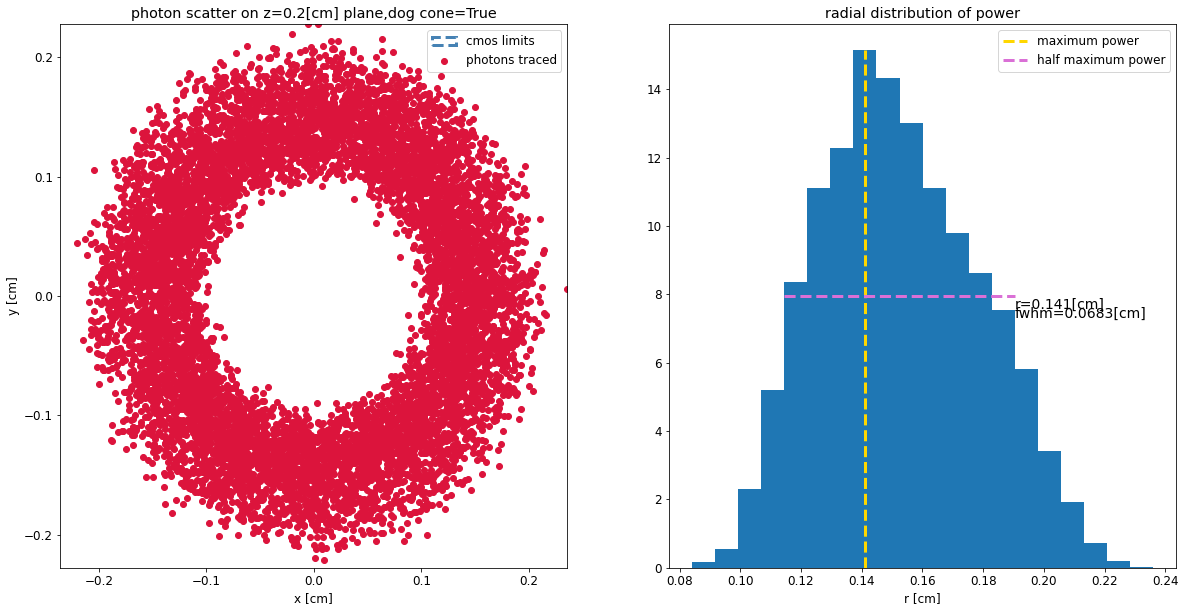

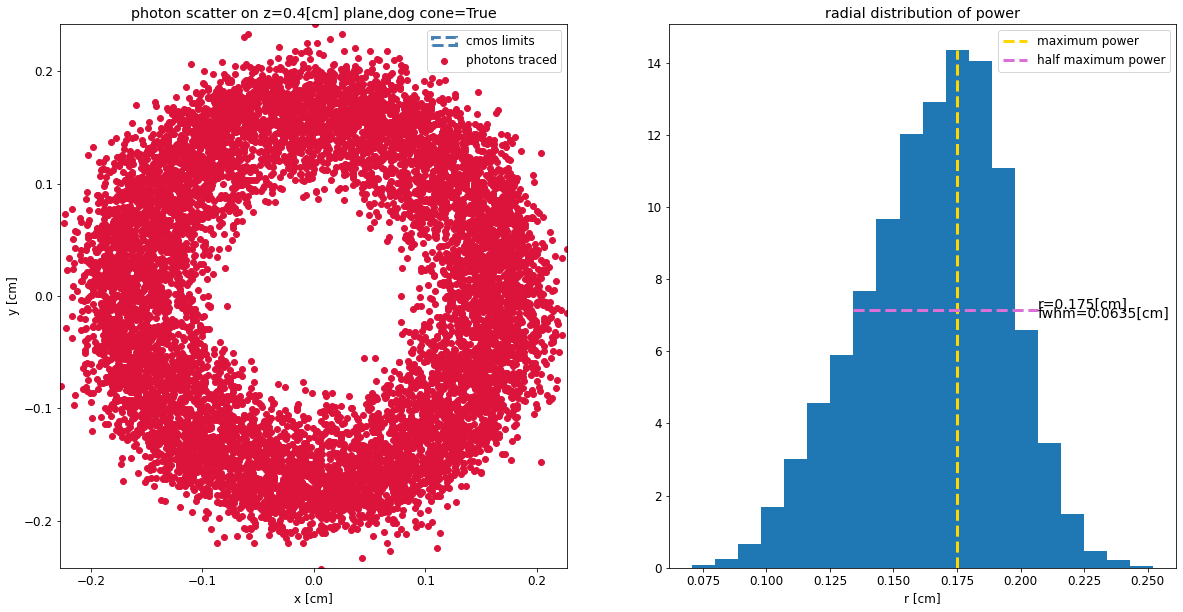

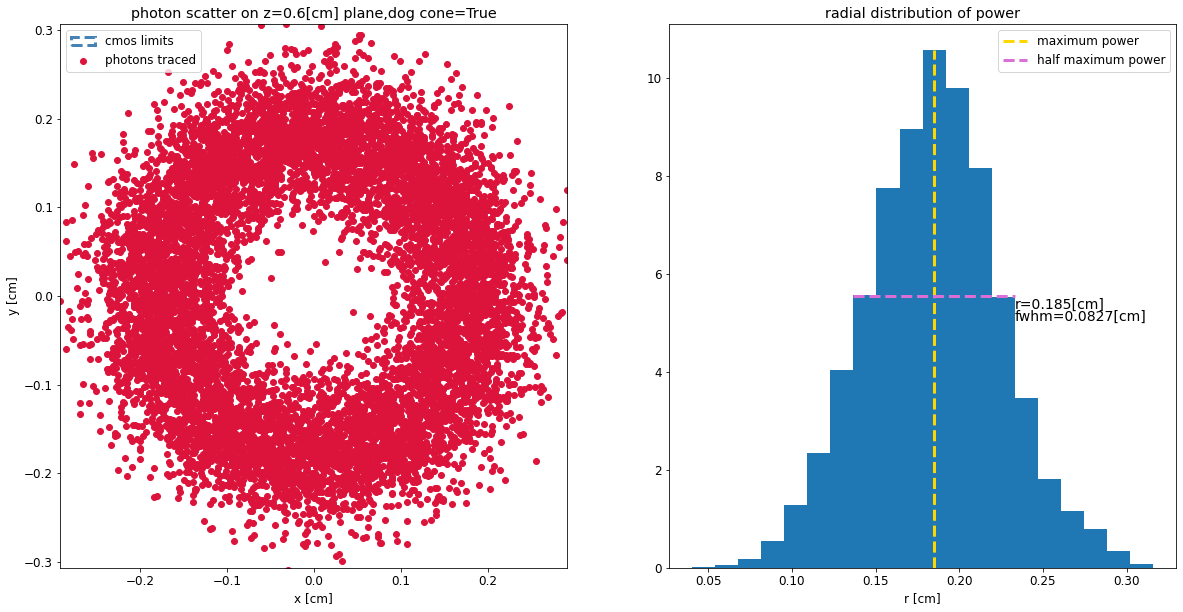

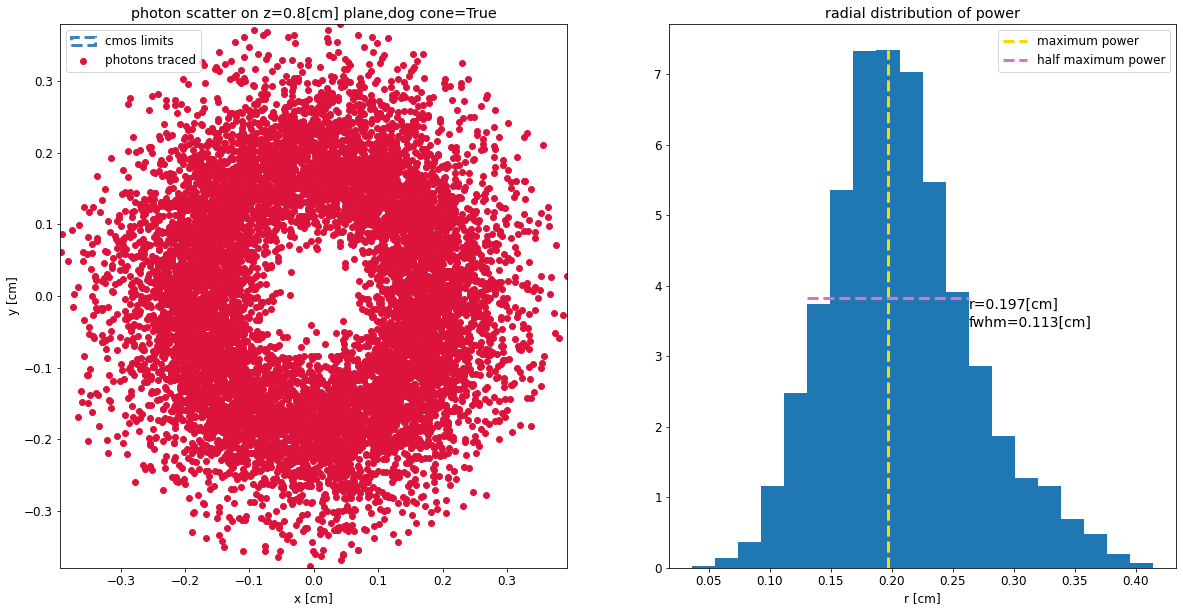

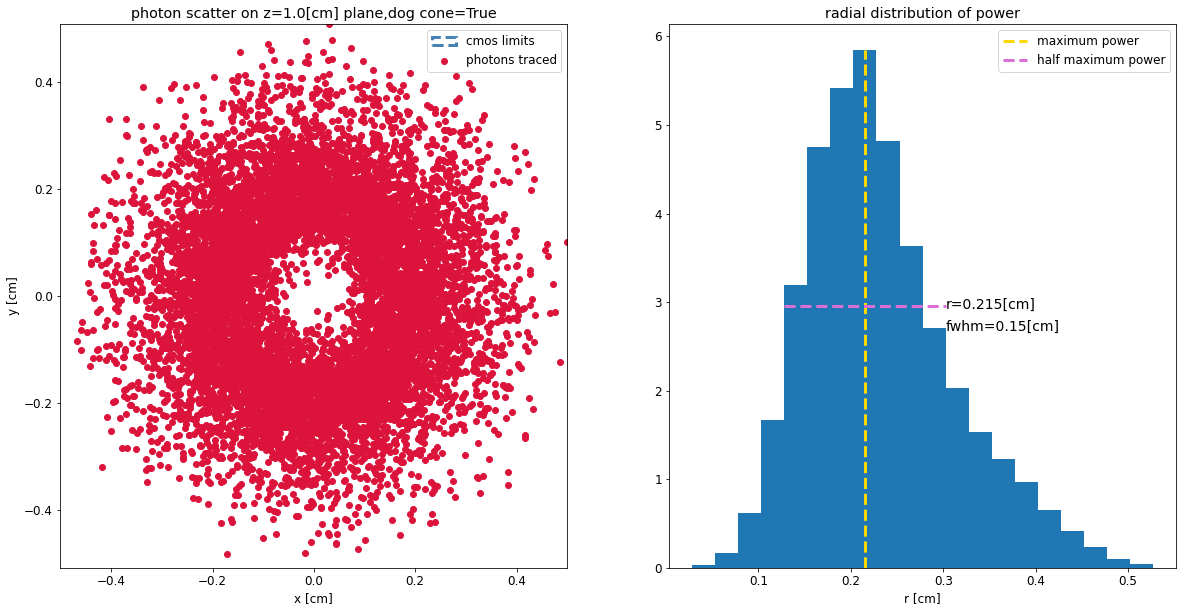

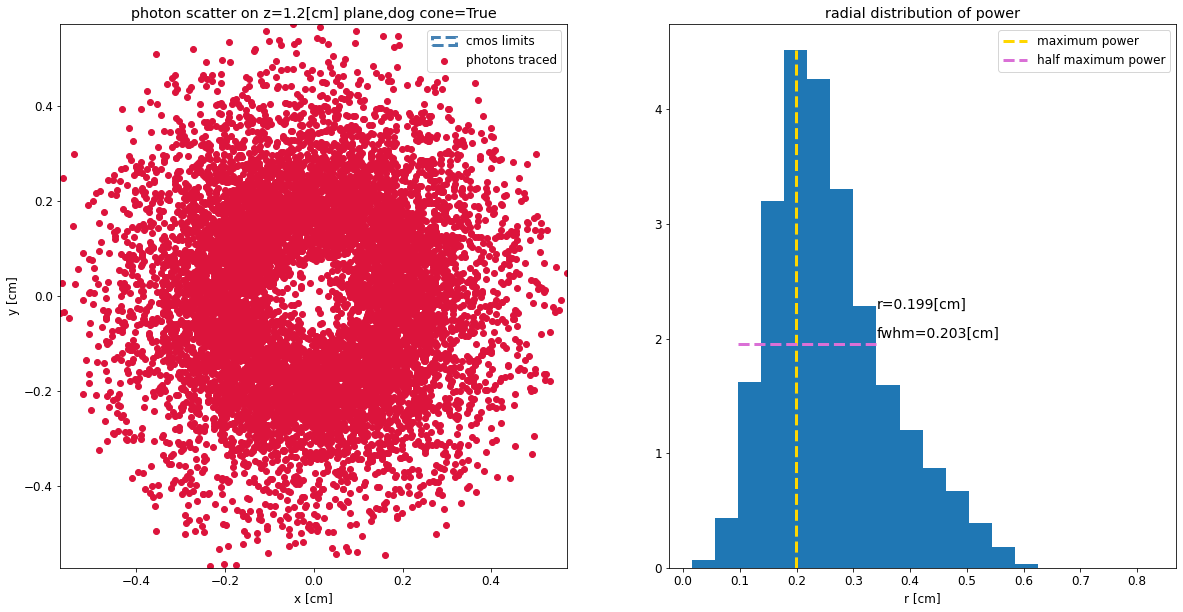

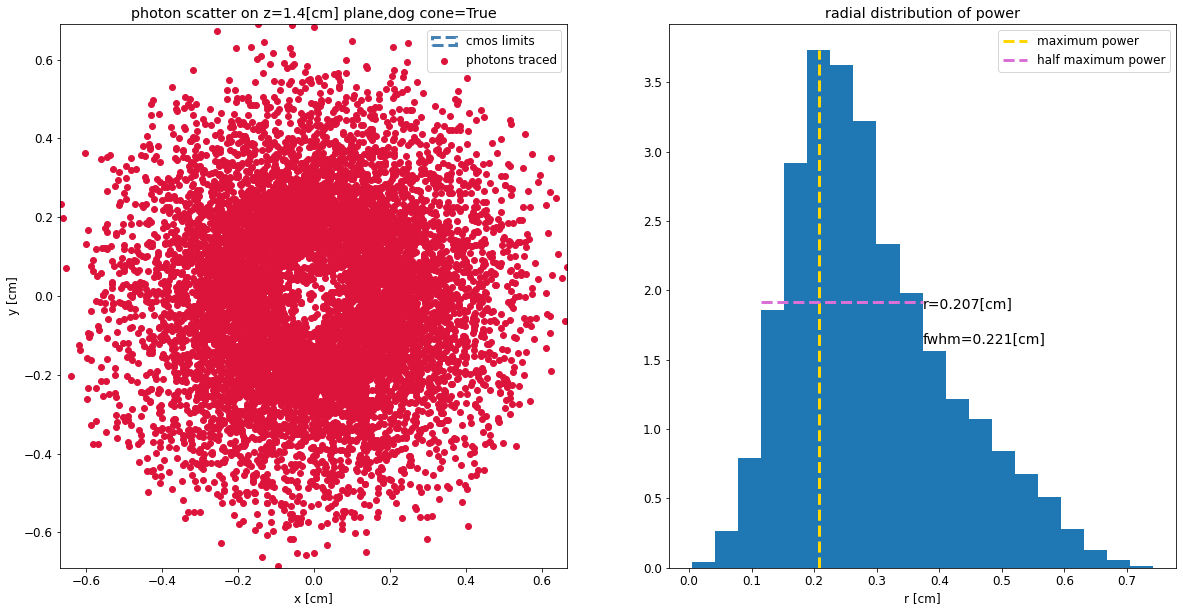

In [6]:
# without dog cones
dis_arr = np.linspace(0.2,1.4,num=7,endpoint=True)
rmax_arr = np.zeros(len(dis_arr))
fwhm_arr = np.zeros(len(dis_arr))

for i in range(len(dis_arr)):
    rmax_arr[i],fwhm_arr[i] = CMOS_projection(45,2,10000,dis_arr[i],cone=True)

In [7]:
import warnings
%pylab inline
warnings.simplefilter("ignore")

!pip install -q matplotlib-venn iminuit
from iminuit import Minuit, describe
from iminuit.util import make_func_code

from matplotlib.offsetbox import AnchoredText

class EffVarChi2Reg:  #This class is like Chi2Regression but takes into account dx
    #this part defines the variables the class will use
    def __init__(self, model, x, y, dx, dy): 
        self.model = model  # model predicts y value for given x value  
        self.x = array(x) #the x values
        self.y = array(y) #the y values
        self.dx = array(dx) #the x-axis uncertainties 
        self.dy = array(dy) #the y-axis uncertainties 
        self.func_code = make_func_code(describe(self.model)[1:])
        self.h = (x[-1]-x[0])/10000  #this is the step size for the numerical calculation of the df/dx = last value in x (x[-1]) - first value in x (x[0])/10000

    #this part defines the calculations when the function is called
    def __call__(self, *par):  # par are a variable number of model parameters
        self.ym = self.model(self.x, *par)
        df = (self.model(self.x + self.h, *par)-self.ym)/self.h #the derivative df/dx at point x is taken as [f(x+h)-f(x)]/h
        chi2 = sum(((self.y - self.ym)**2)/(self.dy**2+(df * self.dx)**2))#chi2 is now Sum of: (f(x)-y)^2/(uncert_y^2+(df/dx*uncert_x)^2)
        return chi2
    
    #this part defines a function called "show" which will make a nice plot when invoked
    def show(self, optimizer, x_title="X", y_title="Y", goodness_loc=2,label=''):
        self.par = optimizer.parameters
        self.chi2 = optimizer.fval
        self.ndof = len(self.x) - len(self.par)
        self.chi_ndof = self.chi2 / self.ndof
        self.par_values = optimizer.values
        self.par_errors = optimizer.errors
        text=""
        for _ in (self.par):
            text += "%s = %0.4f \u00B1 %0.4f \n"%(_,self.par_values[_],self.par_errors[_]) 
            
        text = text + "\u03C7\u00B2 /ndof = %0.4f(%0.4f/%d)"%(self.chi_ndof, self.chi2, self.ndof)    
        self.func_x = np.linspace(self.x[0],self.x[-1] ,10000) # 10000 linearly spaced numbers
        self.y_fit = self.model(self.func_x, *self.par_values)
        plt.rc("font", size=16, family="Times New Roman")
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_axes([0,0,1,1])
        ax.plot(self.func_x,self.y_fit) #plot the function over 10k points covering the x axis
        ax.scatter(self.x,self.y, c="red")
        #ax.errorbar(self.x, self.y, self.dy, self.dy,fmt='none',ecolor='red', capsize=3) typo here I think! dy twice instead of dy, dx
        ax.errorbar(self.x, self.y, self.dy, self.dx,fmt='none',ecolor='red', capsize=3)
        ax.set_xlabel(x_title, fontdict={"size":21})
        ax.set_ylabel(y_title,fontdict={"size":21})
        ax.title.set_text(label)
        anchored_text = AnchoredText(text, loc=goodness_loc)
        ax.add_artist(anchored_text)
        plt.grid(True)

Populating the interactive namespace from numpy and matplotlib


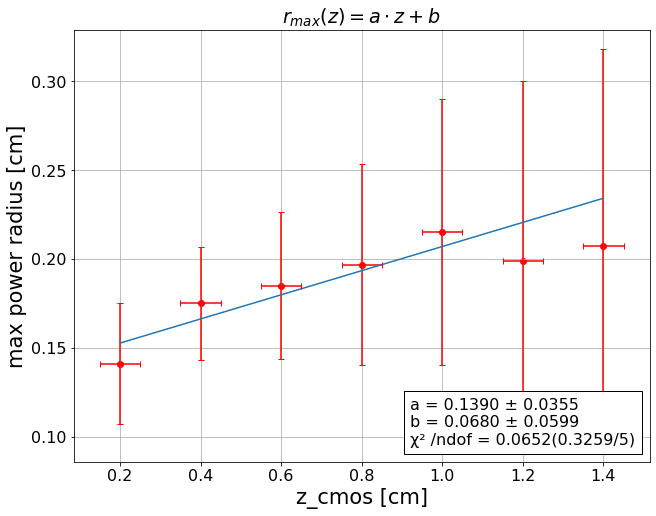

In [9]:
linear_fun = lambda x,a,b: a + (x * b) #just note that in practice it will be used for the same thing but in "coding" terms this is a different variable x than x in the class def above

#Now we create a regression object (from the class defined above) with our example data and function
efvtest = EffVarChi2Reg(linear_fun, dis_arr, rmax_arr, 0.05, 0.5*fwhm_arr)  #the syntax for EffVarChi2Reg is (function, x,y,dx,dy)

#Feed the regression object we just made to Minuit
efopt = Minuit(efvtest,a=1,b=-1) #the syntax is similar the same as when using Chi2Regression or any other function that Minuit works with, i.e. you could put limits etc here also

#Run the minimization
efopt.migrad()

v = np.array(efopt.values) 
u = np.array(efopt.errors)
number_param = len(list(efopt.values))
ndof = len(dis_arr) - number_param
chi2_ndof = efopt.fval/ndof
efvtest.show(efopt, goodness_loc=4, x_title="z_cmos [cm]", y_title="max power radius [cm]",label=r'$r_{max}(z)=a\cdot z+b$')